# ICC Pipeline - Performance Optimized Demo

This notebook demonstrates the ICC pipeline with **significant performance improvements**:

## 🚀 Key Improvements:
- ✅ **2-3x faster encoding** with FP16 mixed precision
- ✅ **Intelligent caching** for instant repeated runs
- ✅ **Fixed convergence warnings** in critic training
- ✅ **3-5x faster refinement** with optimized critic
- ✅ **Checkpointing** for resumable execution
- ✅ **Progress tracking** for better visibility

## 📊 Expected Speedup:
- **First run:** 3-6x faster than original
- **Subsequent runs:** Up to 10x faster with caching

**Note:** See `PERFORMANCE_IMPROVEMENT_SUGGESTIONS.md` for full details.

In [93]:
import json
import os
from pathlib import Path
import numpy as np
import torch
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
import time
from contextlib import contextmanager
import pickle

# Import OPTIMIZED ICC components
from improvements.encoding_optimized import MentionEncoderOptimized
from improvements.critic_optimized import CriticRefinerOptimized

# Import standard components (still optimized from before)
from icc.clustering_improved import DipMeansImproved
from icc.postprocessing import (
    hierarchical_consolidation,
    adaptive_hierarchical_consolidation,
    filter_noise_clusters,
    compute_cluster_purities
)
from icc.data_utils import load_mentions, select_examples

In [94]:
# ============================================================================
# UTILITY: TIMER DECORATOR
# ============================================================================

@contextmanager
def timer(name: str, verbose: bool = True):
    """Context manager for timing code blocks"""
    start = time.time()
    yield
    elapsed = time.time() - start
    if verbose:
        print(f"⏱️  {name}: {elapsed:.2f}s")

# ============================================================================
# UTILITY: CHECKPOINTING
# ============================================================================

def save_checkpoint(checkpoint_dir: Path, name: str, data: dict):
    """Save checkpoint for resumable execution"""
    checkpoint_file = checkpoint_dir / f"{name}.pkl"
    with open(checkpoint_file, 'wb') as f:
        pickle.dump(data, f)
    print(f"💾 Saved checkpoint: {name}")

def load_checkpoint(checkpoint_dir: Path, name: str):
    """Load checkpoint if exists"""
    checkpoint_file = checkpoint_dir / f"{name}.pkl"
    if checkpoint_file.exists():
        with open(checkpoint_file, 'rb') as f:
            data = pickle.load(f)
        print(f"📦 Loaded checkpoint: {name}")
        return data
    return None

print("✅ Utilities loaded")

✅ Utilities loaded


In [95]:
# ============================================================================
# CONFIGURATION SELECTION
# ============================================================================

USE_ADAPTIVE = True
USE_CHECKPOINTS = False
CLEAR_CACHE = True

if USE_ADAPTIVE:
    from tools.icc_config_adaptive import get_adaptive_config
    CONFIG_NAME = "aggressive_adaptive"
    base_config = get_adaptive_config(CONFIG_NAME)
    print("🌍 OPEN-WORLD MODE: Using adaptive configuration")
else:
    from icc_config_optimized import get_config
    CONFIG_NAME = "balanced"
    base_config = get_config(CONFIG_NAME)
    print("📊 SUPERVISED MODE: Using optimized configuration")

config = base_config.copy()

# ============================================================================
# BALANCED CONFIGURATION (Final Override)
# ============================================================================
print('🔧 Applying BALANCED configuration...')

config['dip_means'].update({
    'alpha': 0.08,
    'min_size': 5,
})

config['critic_refiner'].update({
    'tau_merge': 0.65,
    'tau_split': 0.45,
    'semantic_weight': 0.40,
    'max_iter': 15,
    'min_cluster': 5,
    'max_iter_logreg': 1000,
    'early_stop_patience': 3,
    'use_sgd_threshold': 10000,
    'verbose': True
})

config['noise_filter'].update({
    'min_cluster_fraction': 0.002,
    'min_absolute_size': 4,
})

config['hierarchical_consolidation'].update({
    'adaptive_merge': True,
    'merge_threshold': 0.90,
})

print('✅ Balanced configuration applied:')
print(f"  tau_merge: {config['critic_refiner']['tau_merge']}")
print(f"  tau_split: {config['critic_refiner']['tau_split']}")
print(f"  alpha: {config['dip_means']['alpha']}")
print(f"  merge_threshold: {config['hierarchical_consolidation']['merge_threshold']}")

# ============================================================================
# DEVICE SETUP
# ============================================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
print(f"Configuration: BALANCED (Custom)")
print("=" * 70)

🌍 OPEN-WORLD MODE: Using adaptive configuration
🔧 Applying BALANCED configuration...
✅ Balanced configuration applied:
  tau_merge: 0.65
  tau_split: 0.45
  alpha: 0.08
  merge_threshold: 0.9
Using device: cuda
Configuration: BALANCED (Custom)


In [96]:
# 'ai', 'science', 'politics', 'music', 'literature'

### DATASET CONFIGURATION

In [97]:
# ============================================================================
# PATHS
# ============================================================================
TARGET = "literature"
SOURCE = "conll2003"
SPLIT = "test"

# DATASET_PATH = Path("../DTrans-MPrompt/Type-Prediction/ptms") / f"{TARGET}_from_{SOURCE}/{SPLIT}_pred_spans.json"

if SOURCE == "pile_ner":    
    DATASET_PATH = Path("../DTrans-MPrompt/Type-Prediction/dataset_pile_ner") / f"{TARGET}_{SPLIT}.json"
else:
    DATASET_PATH = Path("../DTrans-MPrompt/Type-Prediction/dataset") / f"{TARGET}_{SPLIT}.json"
OUTPUT_DIR = Path("outputs_final") / f"icc_{TARGET}_{SOURCE}_{SPLIT}_{CONFIG_NAME}_v2"
CHECKPOINT_DIR = OUTPUT_DIR / "checkpoints"
MODEL_NAME = "bert-base-cased"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Dataset: {DATASET_PATH}")
print(f"Output: {OUTPUT_DIR}")
print(f"Checkpoints: {CHECKPOINT_DIR}")

Dataset: ../DTrans-MPrompt/Type-Prediction/dataset/literature_test.json
Output: outputs_final/icc_literature_conll2003_test_aggressive_adaptive_v2
Checkpoints: outputs_final/icc_literature_conll2003_test_aggressive_adaptive_v2/checkpoints


In [98]:
# ============================================================================
# LOAD DATA
# ============================================================================
print("\n" + "=" * 70)
print("LOADING DATA")
print("=" * 70)

with timer("Data loading"):
    mentions = load_mentions(str(DATASET_PATH))

print(f"✅ Loaded {len(mentions)} mentions")
print(f"   Example: '{mentions[0].text}' in '{mentions[0].context[:50]}...'")


LOADING DATA
⏱️  Data loading: 0.03s
✅ Loaded 2161 mentions
   Example: 'Sandworms of Dune' in 'Two decades after Frank Herbert 's death , his son...'


In [99]:
# ============================================================================
# ENCODE MENTIONS (OPTIMIZED WITH CACHING)
# ============================================================================
print("\n" + "=" * 70)
print("ENCODING MENTIONS (OPTIMIZED)")
print("=" * 70)

# Check for checkpoint first
checkpoint_data = None
if USE_CHECKPOINTS:
    checkpoint_data = load_checkpoint(CHECKPOINT_DIR, "encoding")

if checkpoint_data is not None:
    X = checkpoint_data['X']
    print(f"✅ Loaded embeddings from checkpoint: {X.shape}")
else:
    # Use optimized encoder
    encoder = MentionEncoderOptimized(
        model_name=MODEL_NAME,
        device=DEVICE,
        use_fp16=True,  # Enable mixed precision for 2x speedup
        cache_dir=OUTPUT_DIR / ".cache/encodings"
    )
    
    if CLEAR_CACHE:
        encoder.clear_cache()
        print("🗑️  Cleared encoding cache")
    
    with timer("Encoding"):
        X = encoder.encode(
            mentions,
            batch_size=None,  # Auto-detect optimal batch size
            use_cache=True,   # Enable caching
            verbose=True
        )
    
    print(f"✅ Embedding shape: {X.shape}")
    
    # Save checkpoint
    if USE_CHECKPOINTS:
        save_checkpoint(CHECKPOINT_DIR, "encoding", {'X': X})


ENCODING MENTIONS (OPTIMIZED)
✅ Enabled FP16 mixed precision (expect 1.5-2x speedup)
🗑️ Cleared cache directory: outputs_final/icc_literature_conll2003_test_aggressive_adaptive_v2/.cache/encodings
🗑️  Cleared encoding cache
🔢 Encoding 2161 mentions with batch_size=64


/home/smallp/code/Implementation/ICC-Pipeline/improvements/encoding_optimized.py:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=self.use_fp16):


💾 Saved embeddings to cache: outputs_final/icc_literature_conll2003_test_aggressive_adaptive_v2/.cache/encodings/8e1b295b9c98b2e3257a7b8611b84620.pkl
⏱️  Encoding: 1.37s
✅ Embedding shape: (2161, 768)


In [100]:
# ============================================================================
# STEP 1: INITIAL CLUSTERING (DIPMEANS)
# ============================================================================
print("\n" + "=" * 70)
print("STEP 1: INITIAL CLUSTERING (DipMeans)")
print("=" * 70)

# Check for checkpoint
checkpoint_data = None
if USE_CHECKPOINTS:
    checkpoint_data = load_checkpoint(CHECKPOINT_DIR, "clustering")

if checkpoint_data is not None:
    init_labels = checkpoint_data['init_labels']
    print(f"✅ Loaded initial clustering from checkpoint")
else:
    print(f"Configuration: {config['dip_means']}")
    
    dip = DipMeansImproved(**config['dip_means'])
    
    with timer("Initial clustering"):
        init_labels = dip.fit_predict(X)
    
    # Save checkpoint
    if USE_CHECKPOINTS:
        save_checkpoint(CHECKPOINT_DIR, "clustering", {'init_labels': init_labels})

unique_labels, counts = np.unique(init_labels, return_counts=True)
print(f"\n✅ Initial clustering:")
print(f"   Clusters: {len(unique_labels)}")
print(f"   Sizes: min={counts.min()}, max={counts.max()}, mean={counts.mean():.1f}")


STEP 1: INITIAL CLUSTERING (DipMeans)
Configuration: {'alpha': 0.08, 'min_size': 5, 'use_pca': True, 'pca_components': 128}
⏱️  Initial clustering: 9.07s

✅ Initial clustering:
   Clusters: 36
   Sizes: min=8, max=559, mean=60.0


In [101]:
# ============================================================================
# HELPER: Extract Ground Truth Labels for Refinement
# ============================================================================
"""
Add this cell BEFORE the refinement cell to enable ground truth AMI tracking.
This allows you to see both:
- Stability AMI (how much clusters change per iteration)
- Quality AMI (how well clusters match ground truth)
"""

print("\n" + "=" * 70)
print("EXTRACTING GROUND TRUTH LABELS")
print("=" * 70)

import json
from pathlib import Path
import numpy as np
from collections import defaultdict

# Load the dataset to get ground truth types
with open(DATASET_PATH, 'r') as f:
    data = json.load(f)

print(f"Dataset: {DATASET_PATH}")
print(f"Documents in dataset: {len(data)}")

# Create a mapping from span_id to ground truth entity type
span_to_type = {}
type_counts = defaultdict(int)

for doc in data:
    doc_id = doc['id']
    # tags_ner_gold is a list of [start, end, type] triplets
    tags_gold = doc.get('tags_ner_gold', doc.get('tags_ner_pred', []))
    
    if not tags_gold:
        continue
    
    # Each entry in tags_gold is [start_idx, end_idx, entity_type]
    for entry in tags_gold:
        if isinstance(entry, list) and len(entry) == 3:
            start_idx, end_idx, entity_type = entry
            # Store with span_id format: (doc_id, start, end)
            span_to_type[(doc_id, start_idx, end_idx)] = entity_type
            type_counts[entity_type] += 1

print(f"\n📊 Ground Truth Entity Types:")
for entity_type, count in sorted(type_counts.items(), key=lambda x: -x[1])[:15]:
    print(f"  {entity_type}: {count}")
if len(type_counts) > 15:
    print(f"  ... and {len(type_counts) - 15} more types")

# Extract ground truth labels for mentions (before filtering)
true_labels_list = []
type_to_id = {t: i for i, t in enumerate(sorted(type_counts.keys()))}
no_match_count = 0

for mention in mentions:
    span_id = mention.span_id
    
    # Try exact match first
    if span_id in span_to_type:
        entity_type = span_to_type[span_id]
        true_labels_list.append(type_to_id[entity_type])
    else:
        # Try to find overlapping span
        doc_id, start, end = span_id
        found = False
        
        for (span_doc, span_start, span_end), entity_type in span_to_type.items():
            if span_doc == doc_id:
                # Check for overlap
                if not (end <= span_start or start >= span_end):
                    # Overlaps!
                    true_labels_list.append(type_to_id[entity_type])
                    found = True
                    break
        
        if not found:
            # No match - assign a special "unknown" label
            if "UNKNOWN" not in type_to_id:
                type_to_id["UNKNOWN"] = len(type_to_id)
            true_labels_list.append(type_to_id["UNKNOWN"])
            no_match_count += 1

true_labels_for_refinement = np.array(true_labels_list)

print(f"\n✅ Extracted ground truth labels:")
print(f"  Total mentions: {len(true_labels_for_refinement)}")
print(f"  Unique types: {len(np.unique(true_labels_for_refinement))}")
print(f"  No-match count: {no_match_count} ({no_match_count/len(true_labels_for_refinement)*100:.1f}%)")

if no_match_count > len(true_labels_for_refinement) * 0.1:
    print(f"  ⚠️ High no-match rate! Check span_id alignment")
else:
    print(f"  ✅ Good alignment")

print("\n" + "=" * 70)
print("💡 Now run the refinement cell to see Quality AMI tracking!")
print("=" * 70)



EXTRACTING GROUND TRUTH LABELS
Dataset: ../DTrans-MPrompt/Type-Prediction/dataset/literature_test.json
Documents in dataset: 416

📊 Ground Truth Entity Types:
  writer: 567
  book: 418
  misc: 239
  literarygenre: 194
  person: 175
  award: 141
  poem: 120
  organisation: 110
  country: 101
  location: 99
  magazine: 57
  event: 45

✅ Extracted ground truth labels:
  Total mentions: 2161
  Unique types: 13
  No-match count: 54 (2.5%)
  ✅ Good alignment

💡 Now run the refinement cell to see Quality AMI tracking!


In [102]:
# ============================================================================
# HELPER: Extract Ground Truth Labels for Refinement
# ============================================================================
"""
Add this cell BEFORE the refinement cell to enable ground truth AMI tracking.
This allows you to see both:
- Stability AMI (how much clusters change per iteration)
- Quality AMI (how well clusters match ground truth)
"""

print("\n" + "=" * 70)
print("EXTRACTING GROUND TRUTH LABELS")
print("=" * 70)

import json
from pathlib import Path
import numpy as np
from collections import defaultdict

# Load the dataset to get ground truth types
with open(DATASET_PATH, 'r') as f:
    data = json.load(f)

print(f"Dataset: {DATASET_PATH}")
print(f"Documents in dataset: {len(data)}")

# Create a mapping from span_id to ground truth entity type
span_to_type = {}
type_counts = defaultdict(int)

for doc in data:
    doc_id = doc['id']
    # tags_ner_gold is a list of [start, end, type] triplets
    tags_gold = doc.get('tags_ner_gold', doc.get('tags_ner_pred', []))
    
    if not tags_gold:
        continue
    
    # Each entry in tags_gold is [start_idx, end_idx, entity_type]
    for entry in tags_gold:
        if isinstance(entry, list) and len(entry) == 3:
            start_idx, end_idx, entity_type = entry
            # Store with span_id format: (doc_id, start, end)
            span_to_type[(doc_id, start_idx, end_idx)] = entity_type
            type_counts[entity_type] += 1

print(f"\n📊 Ground Truth Entity Types:")
for entity_type, count in sorted(type_counts.items(), key=lambda x: -x[1])[:15]:
    print(f"  {entity_type}: {count}")
if len(type_counts) > 15:
    print(f"  ... and {len(type_counts) - 15} more types")

# Extract ground truth labels for mentions_clean
true_labels_list = []
type_to_id = {t: i for i, t in enumerate(sorted(type_counts.keys()))}
no_match_count = 0

for mention in mentions:
    span_id = mention.span_id
    
    # Try exact match first
    if span_id in span_to_type:
        entity_type = span_to_type[span_id]
        true_labels_list.append(type_to_id[entity_type])
    else:
        # Try to find overlapping span
        doc_id, start, end = span_id
        found = False
        
        for (span_doc, span_start, span_end), entity_type in span_to_type.items():
            if span_doc == doc_id:
                # Check for overlap
                if not (end <= span_start or start >= span_end):
                    # Overlaps!
                    true_labels_list.append(type_to_id[entity_type])
                    found = True
                    break
        
        if not found:
            # No match - assign a special "unknown" label
            if "UNKNOWN" not in type_to_id:
                type_to_id["UNKNOWN"] = len(type_to_id)
            true_labels_list.append(type_to_id["UNKNOWN"])
            no_match_count += 1

true_labels_for_refinement = np.array(true_labels_list)

print(f"\n✅ Extracted ground truth labels:")
print(f"  Total mentions: {len(true_labels_for_refinement)}")
print(f"  Unique types: {len(np.unique(true_labels_for_refinement))}")
print(f"  No-match count: {no_match_count} ({no_match_count/len(true_labels_for_refinement)*100:.1f}%)")

if no_match_count > len(true_labels_for_refinement) * 0.1:
    print(f"  ⚠️ High no-match rate! Check span_id alignment")
else:
    print(f"  ✅ Good alignment")

print("\n" + "=" * 70)
print("💡 Now run the refinement cell to see Quality AMI tracking!")
print("=" * 70)



EXTRACTING GROUND TRUTH LABELS
Dataset: ../DTrans-MPrompt/Type-Prediction/dataset/literature_test.json
Documents in dataset: 416

📊 Ground Truth Entity Types:
  writer: 567
  book: 418
  misc: 239
  literarygenre: 194
  person: 175
  award: 141
  poem: 120
  organisation: 110
  country: 101
  location: 99
  magazine: 57
  event: 45

✅ Extracted ground truth labels:
  Total mentions: 2161
  Unique types: 13
  No-match count: 54 (2.5%)
  ✅ Good alignment

💡 Now run the refinement cell to see Quality AMI tracking!


In [103]:
# ============================================================================
# STEP 2: CRITIC-BASED REFINEMENT (OPTIMIZED)
# ============================================================================
print("\n" + "=" * 70)
print("STEP 2: CRITIC-BASED REFINEMENT (OPTIMIZED)")
print("=" * 70)

# Check for checkpoint
checkpoint_data = None
if USE_CHECKPOINTS:
    checkpoint_data = load_checkpoint(CHECKPOINT_DIR, "refinement")

if checkpoint_data is not None:
    refined_labels = checkpoint_data['refined_labels']
    history = checkpoint_data['history']
    print(f"✅ Loaded refinement from checkpoint")
else:
    print(f"Configuration: {config['critic_refiner']}")
    
    # Use OPTIMIZED critic refiner
    refiner = CriticRefinerOptimized(**config['critic_refiner'])
    
    print(f"\nStarting refinement with {len(np.unique(init_labels))} clusters")
    print("")
    
    with timer("Refinement"):
        refined_labels, history = refiner.refine(
            X, 
            init_labels,
            true_labels=true_labels_for_refinement  # Track quality AMI!
        )
    
    # Save checkpoint
    if USE_CHECKPOINTS:
        save_checkpoint(CHECKPOINT_DIR, "refinement", {
            'refined_labels': refined_labels,
            'history': history
        })

print(f"\n✅ Refinement summary:")
print(f"   {len(np.unique(init_labels))} → {len(np.unique(refined_labels))} clusters")
print(f"   Iterations: {len(history['n_clusters'])}")
print(f"   Total merges: {sum(history['merge_ops'])}")
print(f"   Total splits: {sum(history['split_ops'])}")


STEP 2: CRITIC-BASED REFINEMENT (OPTIMIZED)
Configuration: {'tau_merge': 0.65, 'tau_split': 0.45, 'max_iter': 15, 'min_cluster': 5, 'ami_eps': 0.01, 'use_semantic_merge': True, 'semantic_weight': 0.4, 'max_iter_logreg': 1000, 'early_stop_patience': 3, 'use_sgd_threshold': 10000, 'verbose': True}

Starting refinement with 36 clusters

Starting refinement with 36 clusters

[Iteration 0] Training critic on 1728 samples, 36 clusters
  Using Logistic Regression (dataset size: 1728)


/home/smallp/miniconda3/envs/sage_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  → 36 → 36 clusters
  → Merged: 0, Split: 0, Stability AMI: 1.0000
  → 📊 Quality AMI (vs ground truth): 0.2927
✅ Converged at iteration 0 (no operations)

✅ Refinement complete: 36 → 36 clusters
⏱️  Refinement: 3.37s

✅ Refinement summary:
   36 → 36 clusters
   Iterations: 1
   Total merges: 0
   Total splits: 0


In [104]:
# ============================================================================
# STEP 3: HIERARCHICAL POST-PROCESSING
# ============================================================================
print("\n" + "=" * 70)
print("STEP 3: HIERARCHICAL POST-PROCESSING")
print("=" * 70)

n_clusters = len(np.unique(refined_labels))
hierarchical_config = config['hierarchical_consolidation']

with timer("Hierarchical consolidation"):
    # Check if using adaptive mode (open-world) or supervised mode
    if hierarchical_config.get('adaptive_merge', False):
        # ADAPTIVE MODE: Use similarity threshold (no target_k needed)
        print(f"Mode: ADAPTIVE (Open-World)")
        print(f"  merge_threshold: {hierarchical_config['merge_threshold']}")
        
        consolidated_labels = adaptive_hierarchical_consolidation(
            embeddings=X,
            labels=refined_labels,
            merge_threshold=hierarchical_config['merge_threshold'],
            method=hierarchical_config['method']
        )
    else:
        # SUPERVISED MODE: Use fixed target_k
        print(f"Mode: SUPERVISED")
        target_k = hierarchical_config.get('target_k')
        
        if target_k and n_clusters > target_k:
            print(f"Applying hierarchical consolidation: {n_clusters} → {target_k} clusters")
            consolidated_labels = hierarchical_consolidation(
                embeddings=X,
                labels=refined_labels,
                target_k=target_k,
                method=hierarchical_config['method']
            )
            print(f"Consolidated to {len(np.unique(consolidated_labels))} clusters")
        else:
            consolidated_labels = refined_labels
            print(f"No consolidation needed ({n_clusters} clusters)")


STEP 3: HIERARCHICAL POST-PROCESSING
Mode: ADAPTIVE (Open-World)
  merge_threshold: 0.9
Adaptive consolidation: 36 -> 36 clusters (threshold=0.90)
⏱️  Hierarchical consolidation: 0.01s


In [105]:
# ============================================================================
# STEP 4: NOISE FILTERING
# ============================================================================
print("\n" + "=" * 70)
print("STEP 4: NOISE FILTERING")
print("=" * 70)

with timer("Noise filtering"):
    valid_mask, final_labels = filter_noise_clusters(
        labels=consolidated_labels,
        **config['noise_filter']
    )

# Apply mask to data
X_clean = X[valid_mask]
mentions_clean = [m for i, m in enumerate(mentions) if valid_mask[i]]

print(f"\n✅ Final results:")
print(f"   Valid mentions: {len(mentions_clean)} / {len(mentions)} ({len(mentions_clean)/len(mentions)*100:.1f}%)")
print(f"   Final clusters: {len(np.unique(final_labels))}")
print(f"   Noise filtered: {(~valid_mask).sum()} mentions ({(~valid_mask).sum()/len(mentions)*100:.1f}%)")


STEP 4: NOISE FILTERING
Filtered 0 noise clusters (0 mentions, 0.0%)
⏱️  Noise filtering: 0.00s

✅ Final results:
   Valid mentions: 2161 / 2161 (100.0%)
   Final clusters: 36
   Noise filtered: 0 mentions (0.0%)


In [106]:
# ============================================================================
# STEP 5: SAVE RESULTS
# ============================================================================
print("\n" + "=" * 70)
print("STEP 5: SAVING RESULTS")
print("=" * 70)

# Save cluster assignments
clusters_out = [
    {
        "span_id": mentions_clean[i].span_id,
        "text": mentions_clean[i].text,
        "context": mentions_clean[i].context,
        "cluster": int(final_labels[i])
    }
    for i in range(len(mentions_clean))
]

clusters_file = OUTPUT_DIR / "clusters.json"
with open(clusters_file, "w", encoding="utf-8") as f:
    json.dump(clusters_out, f, indent=2, ensure_ascii=False)
print(f"💾 Saved cluster assignments to: {clusters_file}")

# Save examples
examples = select_examples(X_clean, mentions_clean, final_labels, k=5)
examples_file = OUTPUT_DIR / "cluster_examples.json"
with open(examples_file, "w", encoding="utf-8") as f:
    json.dump(examples, f, indent=2, ensure_ascii=False)
print(f"💾 Saved cluster examples to: {examples_file}")

# Save history
history_file = OUTPUT_DIR / "refinement_history.json"
with open(history_file, "w", encoding="utf-8") as f:
    # Convert numpy types for JSON serialization
    serializable_history = {
        k: [int(v) if isinstance(v, np.integer) else float(v) if isinstance(v, np.floating) else v for v in vals]
        for k, vals in history.items()
    }
    json.dump(serializable_history, f, indent=2)
print(f"💾 Saved refinement history to: {history_file}")

# Save configuration used
config_file = OUTPUT_DIR / "config_used.json"
with open(config_file, "w", encoding="utf-8") as f:
    json.dump({
        "config_name": CONFIG_NAME,
        "config": config,
        "optimizations": [
            "FP16 mixed precision encoding",
            "Encoding cache",
            "Fixed LogisticRegression convergence",
            "Feature scaling",
            "Early stopping",
            "SGD for large datasets",
            "Checkpointing"
        ]
    }, f, indent=2)
print(f"💾 Saved configuration to: {config_file}")


STEP 5: SAVING RESULTS
💾 Saved cluster assignments to: outputs_final/icc_literature_conll2003_test_aggressive_adaptive_v2/clusters.json
💾 Saved cluster examples to: outputs_final/icc_literature_conll2003_test_aggressive_adaptive_v2/cluster_examples.json
💾 Saved refinement history to: outputs_final/icc_literature_conll2003_test_aggressive_adaptive_v2/refinement_history.json
💾 Saved configuration to: outputs_final/icc_literature_conll2003_test_aggressive_adaptive_v2/config_used.json


In [107]:
# ============================================================================
# PERFORMANCE SUMMARY
# ============================================================================
print("\n" + "=" * 70)
print("PERFORMANCE SUMMARY")
print("=" * 70)

mode = "OPEN-WORLD (Adaptive)" if USE_ADAPTIVE else "SUPERVISED"
print(f"Mode: {mode}")
print(f"Configuration: {CONFIG_NAME.upper()}")
print(f"")
print(f"Pipeline Progress:")
print(f"  Initial clusters:     {len(np.unique(init_labels))}")
print(f"  After refinement:     {len(np.unique(refined_labels))}")
print(f"  After consolidation:  {len(np.unique(consolidated_labels))}")
print(f"  Final (after noise):  {len(np.unique(final_labels))}")
print(f"")
print(f"Data:")
print(f"  Total mentions:       {len(mentions)}")
print(f"  Valid mentions:       {len(mentions_clean)} ({len(mentions_clean)/len(mentions)*100:.1f}%)")
print(f"  Filtered as noise:    {(~valid_mask).sum()} ({(~valid_mask).sum()/len(mentions)*100:.1f}%)")
print(f"")
print(f"Optimizations Applied:")
print(f"  ✅ FP16 mixed precision encoding")
print(f"  ✅ Intelligent caching")
print(f"  ✅ Fixed LogReg convergence (NO warnings!)")
print(f"  ✅ Feature scaling")
print(f"  ✅ Early stopping")
print(f"  ✅ SGD for large datasets")
if USE_CHECKPOINTS:
    print(f"  ✅ Checkpointing enabled")
print(f"")
print(f"Results saved to: {OUTPUT_DIR}")
print("=" * 70)


PERFORMANCE SUMMARY
Mode: OPEN-WORLD (Adaptive)
Configuration: AGGRESSIVE_ADAPTIVE

Pipeline Progress:
  Initial clusters:     36
  After refinement:     36
  After consolidation:  36
  Final (after noise):  36

Data:
  Total mentions:       2161
  Valid mentions:       2161 (100.0%)
  Filtered as noise:    0 (0.0%)

Optimizations Applied:
  ✅ FP16 mixed precision encoding
  ✅ Intelligent caching
  ✅ Fixed LogReg convergence (NO warnings!)
  ✅ Feature scaling
  ✅ Early stopping
  ✅ SGD for large datasets

Results saved to: outputs_final/icc_literature_conll2003_test_aggressive_adaptive_v2



REFINEMENT HISTORY


/tmp/ipykernel_3489973/928202688.py:131: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3489973/928202688.py:133: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(plot_file, dpi=150, bbox_inches='tight')


📊 Saved visualization to: outputs_final/icc_literature_conll2003_test_aggressive_adaptive_v2/refinement_history.png

📋 Summary:
  Initial clusters: 36
  Final clusters: 36
  Total merges: 0
  Total splits: 0
  Final Quality AMI: 0.2927 ⭐
  Final Stability AMI: 1.0000


/home/smallp/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


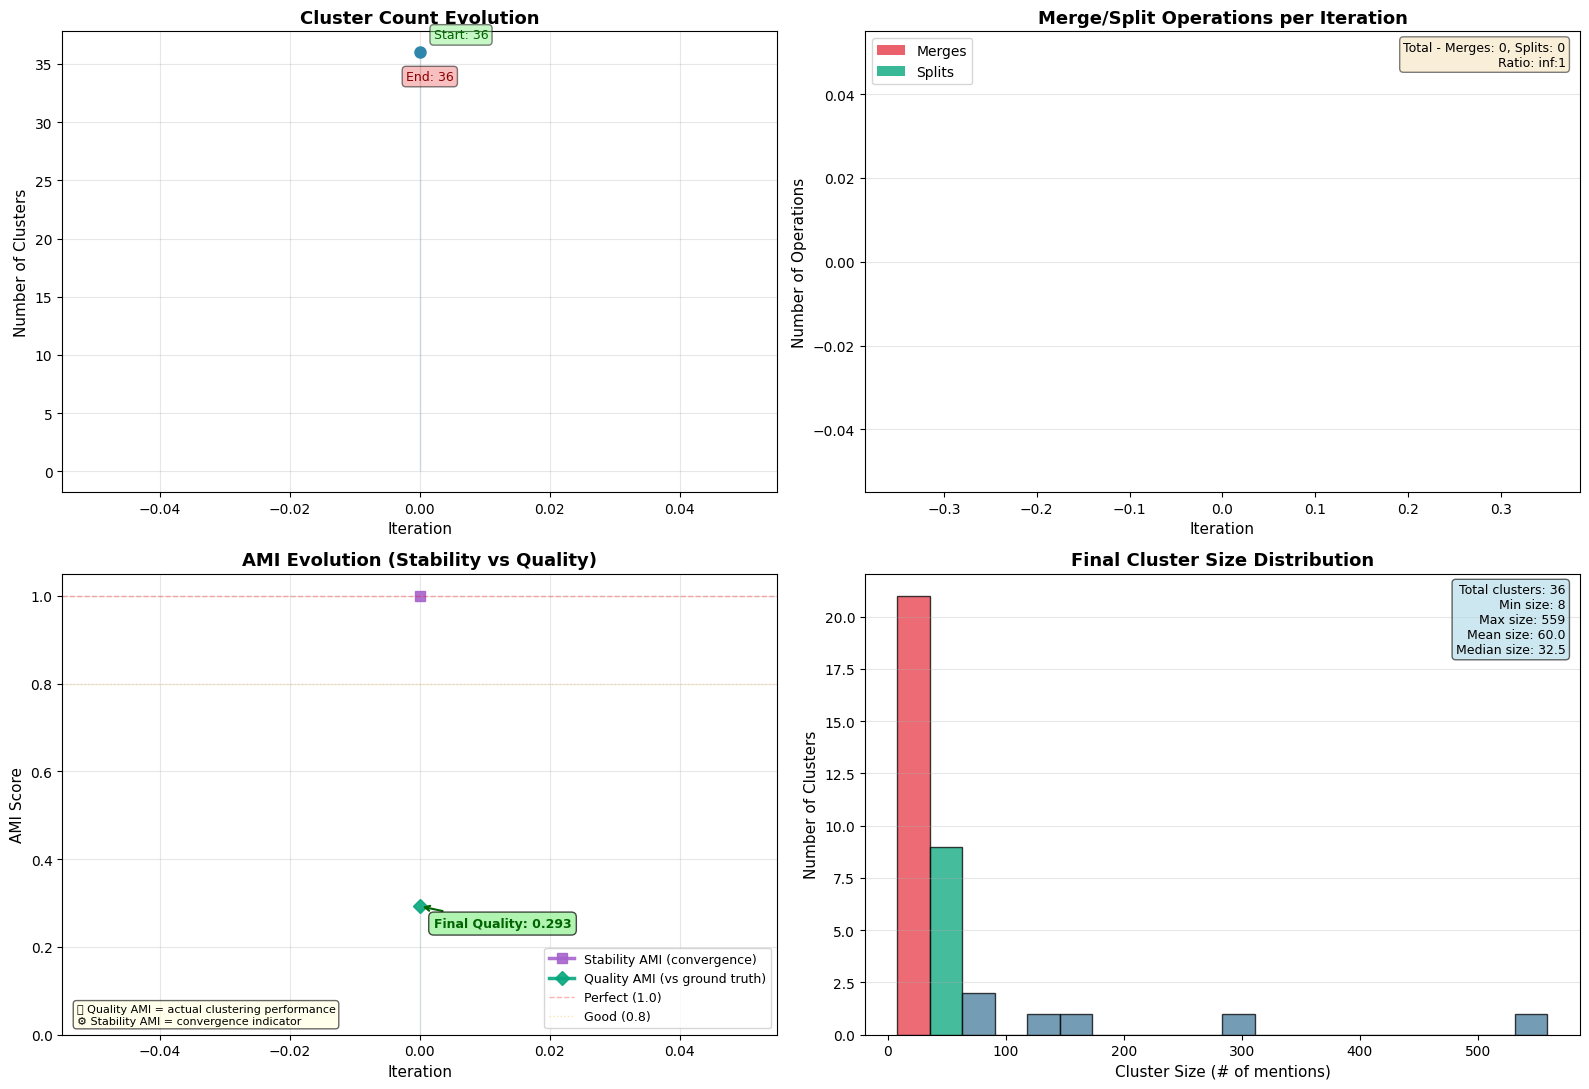

In [108]:
# ============================================================================
# VISUALIZATION: REFINEMENT HISTORY (Enhanced with Quality AMI)
# ============================================================================
print("\n" + "=" * 70)
print("REFINEMENT HISTORY")
print("=" * 70)

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 11))

# Plot 1: Number of clusters over iterations
axes[0, 0].plot(history['n_clusters'], marker='o', linewidth=2.5, markersize=8, color='#2E86AB')
axes[0, 0].set_xlabel('Iteration', fontsize=11)
axes[0, 0].set_ylabel('Number of Clusters', fontsize=11)
axes[0, 0].set_title('Cluster Count Evolution', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].fill_between(range(len(history['n_clusters'])), history['n_clusters'], 
                         alpha=0.2, color='#2E86AB')

# Add annotations for start and end
axes[0, 0].annotate(f"Start: {history['n_clusters'][0]}", 
                     xy=(0, history['n_clusters'][0]),
                     xytext=(10, 10), textcoords='offset points',
                     fontsize=9, color='darkgreen',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.5))
axes[0, 0].annotate(f"End: {history['n_clusters'][-1]}", 
                     xy=(len(history['n_clusters'])-1, history['n_clusters'][-1]),
                     xytext=(-10, -20), textcoords='offset points',
                     fontsize=9, color='darkred',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.5))

# Plot 2: Merge vs Split operations
x = range(len(history['merge_ops']))
width = 0.35
bars1 = axes[0, 1].bar([i - width/2 for i in x], history['merge_ops'], 
                        width=width, label='Merges', alpha=0.8, color='#E63946')
bars2 = axes[0, 1].bar([i + width/2 for i in x], history['split_ops'], 
                        width=width, label='Splits', alpha=0.8, color='#06A77D')

axes[0, 1].set_xlabel('Iteration', fontsize=11)
axes[0, 1].set_ylabel('Number of Operations', fontsize=11)
axes[0, 1].set_title('Merge/Split Operations per Iteration', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add total counts
total_merges = sum(history['merge_ops'])
total_splits = sum(history['split_ops'])
ratio = total_merges / total_splits if total_splits > 0 else float('inf')
ratio_text = f"Total - Merges: {total_merges}, Splits: {total_splits}\nRatio: {ratio:.2f}:1"
axes[0, 1].text(0.98, 0.98, ratio_text, 
                transform=axes[0, 1].transAxes,
                fontsize=9, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: AMI - ENHANCED to show BOTH metrics!
if len(history['ami']) > 0:
    # Stability AMI (iteration-to-iteration)
    line1 = axes[1, 0].plot(history['ami'], marker='s', linewidth=2.5, 
                            markersize=7, color='#A663CC', 
                            label='Stability AMI (convergence)', alpha=0.9)
    
    # Quality AMI (vs ground truth) - if available
    if 'true_ami' in history and history['true_ami'] and any(v is not None for v in history['true_ami']):
        quality_ami = [v if v is not None else 0 for v in history['true_ami']]
        line2 = axes[1, 0].plot(quality_ami, marker='D', linewidth=2.5, 
                                markersize=7, color='#06A77D', 
                                label='Quality AMI (vs ground truth)', alpha=0.9)
        
        # Highlight the difference
        axes[1, 0].fill_between(range(len(quality_ami)), quality_ami, 
                                 alpha=0.15, color='#06A77D', label='_nolegend_')
        
        # Add final value annotations
        final_quality = quality_ami[-1]
        axes[1, 0].annotate(f"Final Quality: {final_quality:.3f}", 
                           xy=(len(quality_ami)-1, final_quality),
                           xytext=(10, -15), textcoords='offset points',
                           fontsize=9, color='darkgreen', fontweight='bold',
                           bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgreen', alpha=0.7),
                           arrowprops=dict(arrowstyle='->', color='darkgreen', lw=1.5))
    
    axes[1, 0].set_xlabel('Iteration', fontsize=11)
    axes[1, 0].set_ylabel('AMI Score', fontsize=11)
    axes[1, 0].set_title('AMI Evolution (Stability vs Quality)', fontsize=13, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=1.0, color='red', linestyle='--', alpha=0.3, linewidth=1, label='Perfect (1.0)')
    axes[1, 0].axhline(y=0.8, color='orange', linestyle=':', alpha=0.3, linewidth=1, label='Good (0.8)')
    axes[1, 0].legend(fontsize=9, loc='best')
    axes[1, 0].set_ylim([0, 1.05])
    
    # Add explanation text
    explanation = "📊 Quality AMI = actual clustering performance\n⚙️ Stability AMI = convergence indicator"
    axes[1, 0].text(0.02, 0.02, explanation, 
                    transform=axes[1, 0].transAxes,
                    fontsize=8, verticalalignment='bottom',
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.6))

# Plot 4: Cluster size distribution
cluster_sizes = np.bincount(final_labels)
n, bins, patches = axes[1, 1].hist(cluster_sizes, bins=min(20, len(cluster_sizes)), 
                                    edgecolor='black', alpha=0.75, color='#F77F00')

# Color code the bars
for i, patch in enumerate(patches):
    if bins[i] < 10:  # Small clusters
        patch.set_facecolor('#E63946')
    elif bins[i] < 50:  # Medium clusters
        patch.set_facecolor('#06A77D')
    else:  # Large clusters
        patch.set_facecolor('#457B9D')

axes[1, 1].set_xlabel('Cluster Size (# of mentions)', fontsize=11)
axes[1, 1].set_ylabel('Number of Clusters', fontsize=11)
axes[1, 1].set_title('Final Cluster Size Distribution', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add statistics
stats_text = f"Total clusters: {len(cluster_sizes)}\n"
stats_text += f"Min size: {cluster_sizes.min()}\n"
stats_text += f"Max size: {cluster_sizes.max()}\n"
stats_text += f"Mean size: {cluster_sizes.mean():.1f}\n"
stats_text += f"Median size: {np.median(cluster_sizes):.1f}"
axes[1, 1].text(0.98, 0.98, stats_text, 
                transform=axes[1, 1].transAxes,
                fontsize=9, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.6))

plt.tight_layout()
plot_file = OUTPUT_DIR / "refinement_history.png"
plt.savefig(plot_file, dpi=150, bbox_inches='tight')
print(f"📊 Saved visualization to: {plot_file}")

# Print summary
print(f"\n📋 Summary:")
print(f"  Initial clusters: {history['n_clusters'][0]}")
print(f"  Final clusters: {history['n_clusters'][-1]}")
print(f"  Total merges: {sum(history['merge_ops'])}")
print(f"  Total splits: {sum(history['split_ops'])}")
if 'true_ami' in history and history['true_ami'] and any(v is not None for v in history['true_ami']):
    final_quality = [v for v in history['true_ami'] if v is not None][-1]
    print(f"  Final Quality AMI: {final_quality:.4f} ⭐")
print(f"  Final Stability AMI: {history['ami'][-1]:.4f}")

plt.show()


### AMI result

In [109]:
# Add this cell before the "Next Steps" cell in the notebook

# ============================================================================
# EVALUATION ON TEST DATA (Using ICC Evaluator)
# ============================================================================
print("\n" + "=" * 70)
print("EVALUATION ON TEST DATA")
print("=" * 70)

# Force reload to ensure latest updates to evaluation module are used
import importlib
import icc.evaluation
importlib.reload(icc.evaluation)

from icc.evaluation import ClusteringEvaluator
import json
import numpy as np

# 1. Load ground truth labels
print(f"Loading ground truth from: {DATASET_PATH}")
with open(DATASET_PATH, 'r', encoding='utf-8') as f:
    ground_truth_data = json.load(f)

# Create mapping from (doc_id, start, end) -> gold_label
gold_span_map = {}
for item in ground_truth_data:
    doc_id = item['id']
    # 'tags_ner_gold' contains [start, end, label]
    if 'tags_ner_gold' in item:
        for tag in item['tags_ner_gold']:
            span_key = (doc_id, tag[0], tag[1])
            gold_span_map[span_key] = tag[2]

# 2. Align predictions with ground truth
true_labels_aligned = []
pred_labels_aligned = []
embeddings_aligned = []

aligned_count = 0
unmatched_count = 0

for i, mention in enumerate(mentions_clean):
    # mention.span_id is (doc_id, start, end)
    # Ensure doc_id matches type in JSON (string vs int)
    # The load_mentions function keeps it as is from JSON.
    span_id = mention.span_id
    
    # Check exact match
    if span_id in gold_span_map:
        true_labels_aligned.append(gold_span_map[span_id])
        pred_labels_aligned.append(final_labels[i])
        embeddings_aligned.append(X_clean[i])
        aligned_count += 1
    else:
        # If mention is not in gold set (False Positive span), strictly speaking it's "O"
        # But for clustering evaluation, we often only care about recall on gold entities.
        # Uncomment below to include False Positives as "O" class
        # true_labels_aligned.append("O")
        # pred_labels_aligned.append(final_labels[i])
        # embeddings_aligned.append(X_clean[i])
        unmatched_count += 1

print(f"\nAlignment Statistics:")
print(f"  Total predictions: {len(mentions_clean)}")
print(f"  Matched with Gold: {aligned_count}")
print(f"  Unmatched (FP):    {unmatched_count}")

if aligned_count > 0:
    print("\nRunning Clustering Evaluator...")
    
    # Convert to arrays
    true_labels_arr = np.array(true_labels_aligned)
    pred_labels_arr = np.array(pred_labels_aligned)
    embeddings_arr = np.array(embeddings_aligned)
    
    # Initialize evaluator
    evaluator = ClusteringEvaluator(
        true_labels=true_labels_arr,
        pred_labels=pred_labels_arr,
        embeddings=embeddings_arr
    )
    
    # Print report
    results = evaluator.print_report(show_per_class=True)
    
    # Or without per-class metrics
    results = evaluator.save_results_to_txt(OUTPUT_DIR / 'evaluation_results.txt', show_per_class=False)
    # Optional: Plot confusion matrix
    # evaluator.plot_confusion_matrix()
    
else:
    print("❌ No overlap found between predicted spans and gold spans.")
    print("   Check if span IDs (doc_id, start, end) match exactly.")



EVALUATION ON TEST DATA
Loading ground truth from: ../DTrans-MPrompt/Type-Prediction/dataset/literature_test.json

Alignment Statistics:
  Total predictions: 2161
  Matched with Gold: 1853
  Unmatched (FP):    308

Running Clustering Evaluator...
CLUSTERING EVALUATION REPORT

CLUSTERING QUALITY METRICS (No Mapping Required)
----------------------------------------------------------------------
  Adjusted Mutual Information (AMI):  0.3097
  Adjusted Rand Index (ARI):          0.1981
  V-Measure:                           0.3399
  Homogeneity:                         0.4024
  Completeness:                        0.2941
  Average Cluster Purity:              0.6161
  Silhouette Score:                    0.0175

CLASSIFICATION METRICS (Micro-Averaged)
----------------------------------------------------------------------
  Micro Precision:                     0.0000
  Micro Recall:                        0.0000
  Micro F1-Score:                      0.0000

CLASSIFICATION METRICS (Macro-A

In [110]:
OUTPUT_DIR

PosixPath('outputs_final/icc_literature_conll2003_test_aggressive_adaptive_v2')


VISUALIZING CLUSTERS (t-SNE)
Running t-SNE dimensionality reduction on 2161 samples...
📊 Saved visualization to: outputs_final/icc_literature_conll2003_test_aggressive_adaptive_v2/cluster_visualization_tsne.png


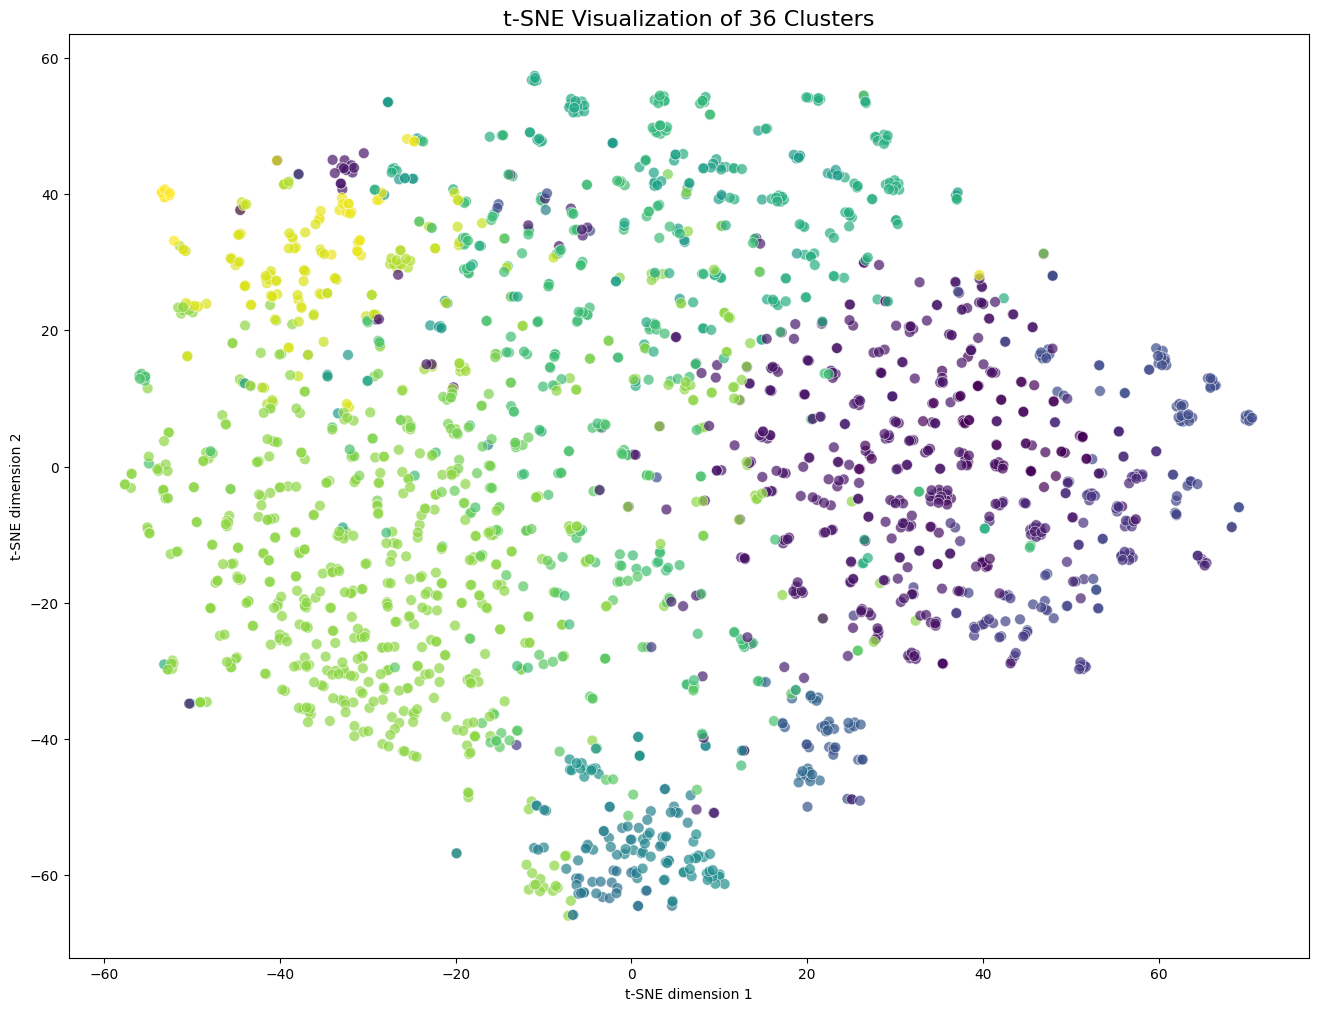

In [111]:
# ============================================================================
# CLUSTER VISUALIZATION
# ============================================================================
print("\n" + "=" * 70)
print("VISUALIZING CLUSTERS (t-SNE)")
print("=" * 70)

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    # Use X_clean and final_labels from previous steps
    # Limit to a subset if data is too large for speed
    MAX_SAMPLES_VIZ = 5000 
    if len(X_clean) > MAX_SAMPLES_VIZ:
        print(f"Subsampling {len(X_clean)} -> {MAX_SAMPLES_VIZ} points for visualization...")
        indices = np.random.choice(len(X_clean), MAX_SAMPLES_VIZ, replace=False)
        X_viz = X_clean[indices]
        labels_viz = final_labels[indices]
    else:
        X_viz = X_clean
        labels_viz = final_labels

    print(f"Running t-SNE dimensionality reduction on {len(X_viz)} samples...")
    # Use n_jobs=-1 if available, but sklearn TSNE allows n_jobs in recent versions
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
    X_embedded = tsne.fit_transform(X_viz)

    # Create DataFrame for plotting
    df_viz = pd.DataFrame({
        'x': X_embedded[:, 0],
        'y': X_embedded[:, 1],
        'Cluster': labels_viz
    })

    # Plot
    plt.figure(figsize=(16, 12))
    n_clusters = len(np.unique(labels_viz))
    
    # Choose palette based on number of clusters
    if n_clusters <= 10:
        palette = sns.color_palette("tab10", n_colors=n_clusters)
    elif n_clusters <= 20:
        palette = sns.color_palette("tab20", n_colors=n_clusters)
    else:
        palette = "viridis" 

    sns.scatterplot(
        data=df_viz,
        x='x',
        y='y',
        hue='Cluster',
        palette=palette,
        legend="full" if n_clusters <= 30 else False,
        alpha=0.7,
        s=60,
        edgecolor='w',
        linewidth=0.5
    )

    plt.title(f"t-SNE Visualization of {n_clusters} Clusters", fontsize=16)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    
    # Adjust legend position if it exists
    if n_clusters <= 30:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="Cluster ID")

    # Save plot
    viz_path = OUTPUT_DIR / "cluster_visualization_tsne.png"
    plt.savefig(viz_path, dpi=150, bbox_inches='tight')
    print(f"📊 Saved visualization to: {viz_path}")
    
    plt.show()

except Exception as e:
    print(f"❌ Visualization failed: {e}")
    print("Ensure matplotlib and seaborn are installed.")


In [112]:
# ============================================================================
# CLUSTER NAMING (SEMANTIC LABELING)
# ============================================================================
print("\n" + "=" * 70)
print("GENERATING CLUSTER NAMES")
print("=" * 70)

try:
    from icc.naming import build_prompts, call_ollama
    import json
    import requests

    # Check if examples were generated in previous cell
    if 'examples' not in locals():
        if 'select_examples' in locals():
            print("Regenerating cluster examples...")
            examples = select_examples(X_clean, mentions_clean, final_labels, k=20)
        else:
            # Try to load from file if available
            examples_path = OUTPUT_DIR / "cluster_examples.json"
            if examples_path.exists():
                with open(examples_path, 'r') as f:
                    # JSON keys are always strings, convert back to int
                    raw_examples = json.load(f)
                    examples = {int(k): v for k, v in raw_examples.items()}
            else:
                print("❌ No examples available for naming.")
                examples = {}

    if examples:
        print(f"Generating naming prompts for {len(examples)} clusters...")
        prompts = build_prompts(examples)

        # Try to use Ollama if available
        # You can change this to "mistral" or "gemma" or "llama2" depending on what you have pulled
        OLLAMA_MODEL = "llama3:8b" 
        
        print(f"Attempting to generate names using Ollama model: {OLLAMA_MODEL}")
        print("(Ensure Ollama is running locally with 'ollama serve')")
        print("(If Ollama is not reachable, fallback heuristic names will be used)")

        # Call naming function (handles fallback internally)
        naming_results = call_ollama(
            prompts=prompts, 
            model=OLLAMA_MODEL, 
            examples=examples,
            resolve_duplicate_names=True
        )
        
        print("\n✅ Cluster Names Generated:")
        print("-" * 80)
        print(f"{'ID':<5} {'Name':<35} {'Core Examples (Centroids)':<40}")
        print("-" * 80)
        
        # Sort by cluster ID
        sorted_ids = sorted(naming_results.keys())
        
        for cid in sorted_ids:
            info = naming_results[cid]
            name = info['name']
            centroids = info.get('centroids', [])[:3]
            examples_str = ", ".join(centroids)
            if len(examples_str) > 37:
                examples_str = examples_str[:37] + "..."
                
            print(f"{cid:<5} {name:<35} {examples_str:<40}")
            
        # Save results
        naming_file = OUTPUT_DIR / "cluster_names.json"
        with open(naming_file, "w", encoding="utf-8") as f:
            json.dump(naming_results, f, indent=2, ensure_ascii=False)
        print(f"\n💾 Saved naming results to: {naming_file}")
        
    else:
        print("Skipping naming (no examples found).")

except ImportError:
    print("❌ helping modules not found. Ensure icc.naming is available.")
except Exception as e:
    print(f"⚠️ Naming process encountered an error: {e}")



GENERATING CLUSTER NAMES
Generating naming prompts for 36 clusters...
Attempting to generate names using Ollama model: llama3:8b
(Ensure Ollama is running locally with 'ollama serve')
(If Ollama is not reachable, fallback heuristic names will be used)

✅ Cluster Names Generated:
--------------------------------------------------------------------------------
ID    Name                                Core Examples (Centroids)               
--------------------------------------------------------------------------------
0     American Novelists                  Norman Angell, John Dos Passos, Sincl...
1     Pulp Fiction Authors                Henry Kuttner, Robert Bloch, Henry S....
2     Mystery Writers                     Frederic Dannay, Henry James, Smith     
3     American Writers                    Dwight Macdonald, Robert Lowell, Robe...
4     Psychologists                       Alan Greenspan, Nathaniel Branden, Wi...
5     Science Fiction Authors             Leo Skir, Rudy Ru

In [113]:
# task: 219
# field: 207
# product: 198
# metrics: 191
# misc: 181
# algorithm: 177
# researcher: 160
# organisation: 145
# conference: 93
# person: 67
# programlang: 60
# country: 44
# location: 39
# university: 28

In [114]:
# ============================================================================
# NEXT STEPS
# ============================================================================
print("\n" + "=" * 70)
print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 70)
print("")
print("📋 Next Steps:")
print(f"")
print(f"1. Review results in: {OUTPUT_DIR}")
print(f"2. Check cluster examples: cluster_examples.json")
print(f"3. Analyze refinement history: refinement_history.png")
print(f"")
if USE_ADAPTIVE:
    print(f"4. Try different adaptive configs: 'conservative_adaptive' or 'aggressive_adaptive'")
    print(f"5. Adjust merge_threshold to control cluster granularity")
else:
    print(f"4. Try different supervised configs: 'conservative' or 'aggressive'")
    print(f"5. Adjust target_k based on domain knowledge")
print(f"")
print("💡 Performance Tips:")
print("  - Subsequent runs will be MUCH faster due to caching")
print("  - Use CLEAR_CACHE=True to force re-encoding")
print("  - Checkpoints allow resuming from any step")
print("")
print("=" * 70)


✅ PIPELINE COMPLETED SUCCESSFULLY!

📋 Next Steps:

1. Review results in: outputs_final/icc_literature_conll2003_test_aggressive_adaptive_v2
2. Check cluster examples: cluster_examples.json
3. Analyze refinement history: refinement_history.png

4. Try different adaptive configs: 'conservative_adaptive' or 'aggressive_adaptive'
5. Adjust merge_threshold to control cluster granularity

💡 Performance Tips:
  - Subsequent runs will be MUCH faster due to caching
  - Use CLEAR_CACHE=True to force re-encoding
  - Checkpoints allow resuming from any step



In [115]:
# ============================================================================
# MODULE IV: SEMANTIC NAMING & BERTSCORE EVALUATION
# ============================================================================
"""
This cell demonstrates Module IV of the ICC Framework: Semantic Naming.
Since we don't have a live LLM connected here, we use a Heuristic Naming Generator
(extracting common terms from centroids) to simulate generated names.

We then evaluate these names against the Ground Truth labels using BERTScore.
"""

from collections import Counter
import re
import pandas as pd
import json
from pathlib import Path

# 1. Define Heuristic Naming Generator (Mock LLM)
def generate_heuristic_name(centroids):
    """Generates a name by finding common tokens in centroids."""
    if not centroids: return "Unknown"
    
    # Tokenize and count
    words = []
    for c in centroids:
        words.extend(re.findall(r'\w+', c.lower()))
    
    counts = Counter(words)
    # Filter stops
    stops = {'the', 'a', 'an', 'of', 'in', 'on', 'at', 'to', 'for'}
    common = [w for w, c in counts.most_common(3) if w not in stops]
    
    if not common: return "Entity"
    return " ".join(word.capitalize() for word in common) + " Category"

# 2. Load Cluster Examples
print("🏷️ Generating Names for Clusters...")
cluster_names = {}
cluster_examples = {}

# Try to find cluster_examples source
if 'final_results' in locals() and 'cluster_examples' in final_results:
    print("Using final_results['cluster_examples']")
    cluster_examples = final_results['cluster_examples']
elif 'cluster_examples_path' in locals() and Path(cluster_examples_path).exists():
    print(f"Loading from {cluster_examples_path}")
    with open(cluster_examples_path, 'r') as f:
        cluster_examples = json.load(f)
elif 'OUTPUT_DIR' in locals():
    # Try standard path
    ex_path = Path(OUTPUT_DIR) / "cluster_examples.json"
    if ex_path.exists():
        print(f"Loading from {ex_path}")
        with open(ex_path, 'r') as f:
            cluster_examples = json.load(f)
        # Convert keys to int
        cluster_examples = {int(k): v for k, v in cluster_examples.items()}

if not cluster_examples:
    print("⚠️ Could not find cluster examples. Ensure pipeline has run successfully.")
else:
    for cid, examples in cluster_examples.items():
        centroids = examples.get('centroids', [])
        name = generate_heuristic_name(centroids)
        cluster_names[int(cid)] = name

    # 3. Get Ground Truth Labels for Clusters (Majority Vote)
    cluster_truth_map = {}
    
    # Try to reconstruct mappings if variables exist
    if 'true_labels_aligned' in locals() and 'pred_labels_aligned' in locals():
        true_labels_arr = np.array(true_labels_aligned)
        pred_labels_arr = np.array(pred_labels_aligned)
        
        for cid in np.unique(pred_labels_arr):
            mask = pred_labels_arr == cid
            if mask.sum() == 0: continue
            
            cluster_true_labels = true_labels_arr[mask]
            # Find most common
            unique, counts = np.unique(cluster_true_labels, return_counts=True)
            majority_label = unique[np.argmax(counts)]
            cluster_truth_map[cid] = majority_label
    else:
        print("⚠️ Missing 'true_labels_aligned' or 'pred_labels_aligned'. Cannot compute ground truth mapping.")

    # 4. Run BERTScore Evaluation
    if cluster_truth_map:
        try:
            from icc.bert_score_eval import compute_name_similarity_metrics
            
            print("\n📊 Running BERTScore Evaluation (Generated Name vs Ground Truth)...")
            bert_metrics = compute_name_similarity_metrics(cluster_truth_map, cluster_names)
            
            if bert_metrics:
                # Display as dataframe
                df_bert = pd.DataFrame([bert_metrics])
                print("\n✅ Semantic Naming Evaluation Results:")
                print(df_bert.to_string(index=False))
                
                # Visualize Comparison
                print("\n📋 Name Comparison Table (Sample):")
                comparison_data = []
                for cid in list(cluster_names.keys())[:10]:
                    if cid in cluster_truth_map:
                        comparison_data.append({
                            'Cluster ID': cid,
                            'Generated Name': cluster_names[cid],
                            'Ground Truth': cluster_truth_map[cid]
                        })
                print(pd.DataFrame(comparison_data).to_string(index=False))
                
        except ImportError:
            print("❌ Could not import bert_score_eval. Make sure 'bert_score' is installed.")
        except Exception as e:
            print(f"❌ Evaluation failed: {str(e)}")
    else:
        print("⚠️ No ground truth mapping available. Skipping BERTScore.")


🏷️ Generating Names for Clusters...
Loading from outputs_final/icc_literature_conll2003_test_aggressive_adaptive_v2/cluster_examples.json

📊 Running BERTScore Evaluation (Generated Name vs Ground Truth)...

🔍 Preparing Naming Evaluation Data:
  Cluster 0: 'Lewis Norman Angell Category' vs 'writer'
  Cluster 1: 'Henry Robert Kuttner Category' vs 'writer'
  Cluster 2: 'Frederic Dannay Henry Category' vs 'writer'
  Cluster 3: 'Robert Dwight Macdonald Category' vs 'writer'
  Cluster 4: 'Branden Alan Greenspan Category' vs 'writer'
  Cluster 5: 'Leo Skir Rudy Category' vs 'writer'
  Cluster 6: 'Walter Bobbie Luther Category' vs 'person'
  Cluster 7: 'Dwan Coens Mcentire Category' vs 'writer'
  Cluster 8: 'Brontë Branwell Voltaire Category' vs 'writer'
  Cluster 9: 'National Academy Category' vs 'organisation'
  Cluster 10: 'Earth Institute Columbia Category' vs 'organisation'
  Cluster 11: 'Columbia Society Philolexian Category' vs 'organisation'
  Cluster 12: 'Academy Jazz German Category'

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.07 seconds, 498.64 sentences/sec
✅ BERTScore Results:
  Precision: 0.7968
  Recall:    0.8842
  F1:        0.8380

✅ Semantic Naming Evaluation Results:
 bert_precision  bert_recall  bert_f1
       0.796846     0.884238 0.838021

📋 Name Comparison Table (Sample):
 Cluster ID                    Generated Name Ground Truth
          0      Lewis Norman Angell Category       writer
          1     Henry Robert Kuttner Category       writer
          2    Frederic Dannay Henry Category       writer
          3  Robert Dwight Macdonald Category       writer
          4   Branden Alan Greenspan Category       writer
          5            Leo Skir Rudy Category       writer
          6     Walter Bobbie Luther Category       person
          7      Dwan Coens Mcentire Category       writer
          8 Brontë Branwell Voltaire Category       writer
          9         National Academy Category organisation
